In [1]:
import sys
sys.path.append('..')

import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"

In [2]:
import taiko as tk
from taiko.tools.config import *
from taiko.play import get_play, get_similarity
from taiko.database import load_record_df
from taiko.performance import get_performance, get_pf_similarity

from itertools import product
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import posixpath
import multiprocessing
from sklearn.preprocessing import StandardScaler

sns.set(font_scale=1.5)

Using TensorFlow backend.


In [3]:
SONG_ID = 1

In [4]:
record_df = load_record_df(song_id=SONG_ID)
record_df

,drummer_name,song_id,left_sensor_datetime,right_sensor_datetime,capture_datetime
1,aaaaa,1,L_2018-09-28_111304.csv,R_2018-09-28_111305.csv,capture_2018_09_28_11_13_05
5,aaaaa,1,L_2018-09-28_112912.csv,R_2018-09-28_112913.csv,capture_2018_09_28_11_29_13
9,aaaaa,1,L_2018-09-28_114340.csv,R_2018-09-28_114340.csv,capture_2018_09_28_11_43_41
13,aaaaa,1,L_2018-09-28_115822.csv,R_2018-09-28_115823.csv,capture_2018_09_28_11_58_23
25,carolyn,1,L_2018-09-27_154913.csv,R_2018-09-27_154916.csv,capture_2018_09_27_15_49_16
29,carolyn,1,L_2018-09-27_160509.csv,R_2018-09-27_160510.csv,capture_2018_09_27_16_05_10
33,carolyn,1,L_2018-09-27_161825.csv,R_2018-09-27_161826.csv,capture_2018_09_27_16_18_26
37,carolyn,1,L_2018-09-27_163110.csv,R_2018-09-27_163111.csv,capture_2018_09_27_16_31_11
42,celiven,1,L_2018-09-22_141822.csv,R_2018-09-22_141821.csv,capture_2018_09_22_14_18_21
46,celiven,1,L_2018-09-22_142958.csv,R_2018-09-22_142957.csv,capture_2018_09_22_14_29_57


In [5]:
play_result_df = pd.read_csv(PLAY_RESULT_TABLE_PATH)
play_result_df.drop(['drummer_name', 'song_id', 'capture_datetime'], axis=1, inplace=True)
play_record_df = record_df.merge(play_result_df, left_index=True, right_on='id', how='inner')
play_record_df['note'] = play_record_df['good'] + play_record_df['ok'] + play_record_df['bad']
play_record_df = play_record_df[play_record_df['note'] == ALL_NOTE_COUNT_DICT[SONG_ID]]
play_record_df.drop('note', axis=1, inplace=True)
play_record_df

,drummer_name,song_id,left_sensor_datetime,right_sensor_datetime,capture_datetime,id,p_order,score,good,ok,bad,max_combo,drumroll
0,aaaaa,1,L_2018-09-28_111304.csv,R_2018-09-28_111305.csv,capture_2018_09_28_11_13_05,1,1,975110,81,5,0,86,78
4,aaaaa,1,L_2018-09-28_112912.csv,R_2018-09-28_112913.csv,capture_2018_09_28_11_29_13,5,2,989360,84,2,0,86,63
8,aaaaa,1,L_2018-09-28_114340.csv,R_2018-09-28_114340.csv,capture_2018_09_28_11_43_41,9,3,979660,84,2,0,86,68
12,aaaaa,1,L_2018-09-28_115822.csv,R_2018-09-28_115823.csv,capture_2018_09_28_11_58_23,13,4,991060,84,2,0,86,74
16,carolyn,1,L_2018-09-27_154913.csv,R_2018-09-27_154916.csv,capture_2018_09_27_15_49_16,25,1,792630,54,30,2,84,42
20,carolyn,1,L_2018-09-27_160509.csv,R_2018-09-27_160510.csv,capture_2018_09_27_16_05_10,29,2,803450,57,25,4,61,48
24,carolyn,1,L_2018-09-27_161825.csv,R_2018-09-27_161826.csv,capture_2018_09_27_16_18_26,33,3,945560,76,10,0,86,49
28,carolyn,1,L_2018-09-27_163110.csv,R_2018-09-27_163111.csv,capture_2018_09_27_16_31_11,37,4,913960,71,15,0,86,47
32,celiven,1,L_2018-09-22_141822.csv,R_2018-09-22_141821.csv,capture_2018_09_22_14_18_21,42,1,978860,82,4,0,86,64
35,celiven,1,L_2018-09-22_142958.csv,R_2018-09-22_142957.csv,capture_2018_09_22_14_29_57,46,2,994710,85,1,0,86,65


In [6]:
full_combo_df = play_record_df[play_record_df['bad'] == 0]
full_combo_df

,drummer_name,song_id,left_sensor_datetime,right_sensor_datetime,capture_datetime,id,p_order,score,good,ok,bad,max_combo,drumroll
0,aaaaa,1,L_2018-09-28_111304.csv,R_2018-09-28_111305.csv,capture_2018_09_28_11_13_05,1,1,975110,81,5,0,86,78
4,aaaaa,1,L_2018-09-28_112912.csv,R_2018-09-28_112913.csv,capture_2018_09_28_11_29_13,5,2,989360,84,2,0,86,63
8,aaaaa,1,L_2018-09-28_114340.csv,R_2018-09-28_114340.csv,capture_2018_09_28_11_43_41,9,3,979660,84,2,0,86,68
12,aaaaa,1,L_2018-09-28_115822.csv,R_2018-09-28_115823.csv,capture_2018_09_28_11_58_23,13,4,991060,84,2,0,86,74
24,carolyn,1,L_2018-09-27_161825.csv,R_2018-09-27_161826.csv,capture_2018_09_27_16_18_26,33,3,945560,76,10,0,86,49
28,carolyn,1,L_2018-09-27_163110.csv,R_2018-09-27_163111.csv,capture_2018_09_27_16_31_11,37,4,913960,71,15,0,86,47
32,celiven,1,L_2018-09-22_141822.csv,R_2018-09-22_141821.csv,capture_2018_09_22_14_18_21,42,1,978860,82,4,0,86,64
35,celiven,1,L_2018-09-22_142958.csv,R_2018-09-22_142957.csv,capture_2018_09_22_14_29_57,46,2,994710,85,1,0,86,65
38,celiven,1,L_2018-09-22_144040.csv,R_2018-09-22_144039.csv,capture_2018_09_22_14_40_39,50,3,989460,84,2,0,86,64
41,celiven,1,L_2018-09-22_145139.csv,R_2018-09-22_145139.csv,capture_2018_09_22_14_51_38,54,4,999560,86,0,0,86,61


In [7]:
# test
# CONSIDERED_IDS = [61, 150]

# doraemon individual
# CONSIDERED_IDS = [1, 33, 61, 99, 150, 180, 241, 254, 288, 323]

# doraemon individual for two occurance
CONSIDERED_IDS = [1, 5, 33, 37, 60, 64, 98, 106, 140, 149, 179, 180, 240, 248, 253, 257, 287, 309, 322, 326]

# RPG individual for two occurance
# CONSIDERED_IDS = [10, 14, 52, 56, 79, 83, 121, 125, 155, 159, 208, 216, 280, 284, 311, 315, 350, 354]

# all
# CONSIDERED_IDS = play_record_df['id'].values

# full_combo
# CONSIDERED_IDS = full_combo_df['id'].values

CONSIDERED_IDS

[1,
 5,
 33,
 37,
 60,
 64,
 98,
 106,
 140,
 149,
 179,
 180,
 240,
 248,
 253,
 257,
 287,
 309,
 322,
 326]

In [8]:
plays = []
with multiprocessing.Pool() as p:
    for _, play in tqdm(enumerate(p.imap(get_play, CONSIDERED_IDS)), total=len(CONSIDERED_IDS)):
        plays.append(play)

play_record_df[play_record_df['id'].isin(CONSIDERED_IDS)]

100%|██████████| 20/20 [00:00<00:00, 127.58it/s]


,drummer_name,song_id,left_sensor_datetime,right_sensor_datetime,capture_datetime,id,p_order,score,good,ok,bad,max_combo,drumroll
0,aaaaa,1,L_2018-09-28_111304.csv,R_2018-09-28_111305.csv,capture_2018_09_28_11_13_05,1,1,975110,81,5,0,86,78
4,aaaaa,1,L_2018-09-28_112912.csv,R_2018-09-28_112913.csv,capture_2018_09_28_11_29_13,5,2,989360,84,2,0,86,63
24,carolyn,1,L_2018-09-27_161825.csv,R_2018-09-27_161826.csv,capture_2018_09_27_16_18_26,33,3,945560,76,10,0,86,49
28,carolyn,1,L_2018-09-27_163110.csv,R_2018-09-27_163111.csv,capture_2018_09_27_16_31_11,37,4,913960,71,15,0,86,47
45,chris,1,L_2018-09-26_133059.csv,R_2018-09-26_133100.csv,capture_2018_09_26_13_30_59,60,1,908230,76,10,0,86,44
49,chris,1,L_2018-09-26_134302.csv,R_2018-09-26_134304.csv,capture_2018_09_26_13_43_03,64,2,987660,85,1,0,86,50
81,cuxi,1,L_2018-09-25_160510.csv,R_2018-09-25_160512.csv,capture_2018_09_25_16_05_13,98,2,942410,77,9,0,86,63
89,cuxi,1,L_2018-09-25_163116.csv,R_2018-09-25_163117.csv,capture_2018_09_25_16_31_18,106,4,974110,81,5,0,86,67
121,eve,1,L_2018-09-26_175516.csv,R_2018-09-26_175517.csv,capture_2018_09_26_17_55_17,140,4,892060,67,19,0,86,39
129,eve,1,L_2018-09-28_163325.csv,R_2018-09-28_163326.csv,capture_2018_09_28_16_33_26,149,6,928410,75,11,0,86,38


In [8]:
pfs = []
for i_, id_ in tqdm(enumerate(CONSIDERED_IDS), total=len(CONSIDERED_IDS)):
    pid = id_
    pf = get_performance(pid)
    pfs.append(pf)

play_record_df[play_record_df['id'].isin(CONSIDERED_IDS)]

100%|██████████| 20/20 [00:00<00:00, 48.87it/s]


,drummer_name,song_id,left_sensor_datetime,right_sensor_datetime,capture_datetime,id,p_order,score,good,ok,bad,max_combo,drumroll
0,aaaaa,1,L_2018-09-28_111304.csv,R_2018-09-28_111305.csv,capture_2018_09_28_11_13_05,1,1,975110,81,5,0,86,78
4,aaaaa,1,L_2018-09-28_112912.csv,R_2018-09-28_112913.csv,capture_2018_09_28_11_29_13,5,2,989360,84,2,0,86,63
24,carolyn,1,L_2018-09-27_161825.csv,R_2018-09-27_161826.csv,capture_2018_09_27_16_18_26,33,3,945560,76,10,0,86,49
28,carolyn,1,L_2018-09-27_163110.csv,R_2018-09-27_163111.csv,capture_2018_09_27_16_31_11,37,4,913960,71,15,0,86,47
45,chris,1,L_2018-09-26_133059.csv,R_2018-09-26_133100.csv,capture_2018_09_26_13_30_59,60,1,908230,76,10,0,86,44
49,chris,1,L_2018-09-26_134302.csv,R_2018-09-26_134304.csv,capture_2018_09_26_13_43_03,64,2,987660,85,1,0,86,50
81,cuxi,1,L_2018-09-25_160510.csv,R_2018-09-25_160512.csv,capture_2018_09_25_16_05_13,98,2,942410,77,9,0,86,63
89,cuxi,1,L_2018-09-25_163116.csv,R_2018-09-25_163117.csv,capture_2018_09_25_16_31_18,106,4,974110,81,5,0,86,67
121,eve,1,L_2018-09-26_175516.csv,R_2018-09-26_175517.csv,capture_2018_09_26_17_55_17,140,4,892060,67,19,0,86,39
129,eve,1,L_2018-09-28_163325.csv,R_2018-09-28_163326.csv,capture_2018_09_28_16_33_26,149,6,928410,75,11,0,86,38


In [8]:
play = []
with multiprocessing.Pool() as p:
    for _, pf in tqdm(enumerate(p.imap(get_play, CONSIDERED_IDS)), total=len(CONSIDERED_IDS)):
        plays.append(play)

play_record_df[play_record_df['id'].isin(CONSIDERED_IDS)]

  0%|          | 0/20 [00:00<?, ?it/s]Process ForkPoolWorker-3:
Process ForkPoolWorker-13:
Process ForkPoolWorker-7:
Process ForkPoolWorker-2:
Process ForkPoolWorker-8:
Process ForkPoolWorker-14:
Process ForkPoolWorker-6:
Process ForkPoolWorker-4:
Process ForkPoolWorker-5:
Process ForkPoolWorker-1:


KeyboardInterrupt: 

In [9]:
HANDS = ['L', 'R']
# _K = 370
# SIMILARITY_COLUMNS = [a + '_' + b for a, b in product(HANDS, ZERO_ADJ_COL)]
# SIMILARITY_COLUMNS = [str(k) + '_' + b for k, b in product(range(_K), SIMILARITY_COLUMNS)]
SIMILARITY_COLUMNS = list(pfs[0].columns)[1:]
# SIMILARITY_COLUMNS = [a + '_' + b for a, b in product(HANDS, SIMILARITY_COLUMNS)]
SIMILARITY_COLUMNS

['L_A_AI',
 'L_G_AI',
 'L_AX_AI',
 'L_AY_AI',
 'L_AZ_AI',
 'L_GX_AI',
 'L_GY_AI',
 'L_GZ_AI',
 'L_A_MMI',
 'L_G_MMI',
 'L_AX_MMI',
 'L_AY_MMI',
 'L_AZ_MMI',
 'L_GX_MMI',
 'L_GY_MMI',
 'L_GZ_MMI',
 'L_A_SMA',
 'L_G_SMA',
 'L_A_FR',
 'L_G_FR',
 'L_AX_FR',
 'L_AY_FR',
 'L_AZ_FR',
 'L_GX_FR',
 'L_GY_FR',
 'L_GZ_FR',
 'L_AXY_CORR',
 'L_AYZ_CORR',
 'L_AZX_CORR',
 'L_GXY_CORR',
 'L_GYZ_CORR',
 'L_GZX_CORR',
 'R_A_AI',
 'R_G_AI',
 'R_AX_AI',
 'R_AY_AI',
 'R_AZ_AI',
 'R_GX_AI',
 'R_GY_AI',
 'R_GZ_AI',
 'R_A_MMI',
 'R_G_MMI',
 'R_AX_MMI',
 'R_AY_MMI',
 'R_AZ_MMI',
 'R_GX_MMI',
 'R_GY_MMI',
 'R_GZ_MMI',
 'R_A_SMA',
 'R_G_SMA',
 'R_A_FR',
 'R_G_FR',
 'R_AX_FR',
 'R_AY_FR',
 'R_AZ_FR',
 'R_GX_FR',
 'R_GY_FR',
 'R_GZ_FR',
 'R_AXY_CORR',
 'R_AYZ_CORR',
 'R_AZX_CORR',
 'R_GXY_CORR',
 'R_GYZ_CORR',
 'R_GZX_CORR']

In [10]:
pfs[0]

,timestamp,L_A_AI,L_G_AI,L_AX_AI,L_AY_AI,L_AZ_AI,L_GX_AI,L_GY_AI,L_GZ_AI,L_A_MMI,...,R_AZ_FR,R_GX_FR,R_GY_FR,R_GZ_FR,R_AXY_CORR,R_AYZ_CORR,R_AZX_CORR,R_GXY_CORR,R_GYZ_CORR,R_GZX_CORR
0,1.538104e+09,1.0422,22.4635,-0.3383,-0.7328,-0.2892,12.3587,12.4741,4.9616,1.0500,...,1.2483,26.0376,55.1879,8.2032,-0.8032,0.0892,0.0705,0.9560,0.2894,0.4700
1,1.538104e+09,0.9907,17.3701,-0.0809,-0.6873,-0.1724,8.6718,2.3487,3.6722,1.0500,...,2.1581,26.0376,78.8208,9.1309,-0.6395,-0.0648,0.4422,0.7242,-0.0209,0.5647
2,1.538104e+09,0.9208,17.1835,-0.0138,-0.6564,-0.1245,6.3295,-0.6994,2.3897,0.9579,...,2.1964,21.6064,90.4174,10.4371,-0.5005,-0.3195,0.2696,0.8489,-0.5060,-0.1054
3,1.538104e+09,0.8909,19.0923,-0.0264,-0.6228,-0.1240,4.3794,4.0659,2.4474,0.8954,...,1.7676,21.6064,90.4174,10.4371,-0.5640,-0.4768,0.3712,0.9365,-0.5409,-0.3048
4,1.538104e+09,0.8778,19.0086,0.0140,-0.6503,0.0072,1.9596,0.1581,5.4839,0.8632,...,1.2899,19.4213,74.2065,6.7811,-0.3142,-0.2595,0.2214,0.9780,-0.3268,-0.4052
5,1.538104e+09,0.9379,22.8417,0.0676,-0.6991,0.0211,2.6286,8.9359,9.1754,0.9513,...,1.3560,18.7133,47.8515,12.2376,-0.5153,-0.0739,-0.0226,0.9595,0.0300,0.2563
6,1.538104e+09,1.0355,26.0506,-0.0417,-0.7702,0.1907,2.8520,12.8922,13.4219,1.0856,...,1.3316,16.3635,39.6362,12.8052,-0.4725,-0.2602,0.1664,0.8115,0.2838,0.4546
7,1.538104e+09,1.2515,23.8827,0.1060,-0.9363,0.3132,2.2377,4.7071,14.9170,1.1957,...,1.3316,10.7788,39.6362,12.8052,-0.1551,-0.4828,0.1820,0.7112,0.4145,0.7639
8,1.538104e+09,1.2542,23.5743,0.2314,-0.9619,0.4150,3.6586,9.7272,13.1305,1.1788,...,1.4221,10.7788,39.6362,12.8052,-0.3366,-0.4402,0.0360,0.7080,0.8099,0.5412
9,1.538104e+09,1.2775,19.8369,0.0225,-0.9678,0.5163,2.2891,5.6150,12.1073,1.2028,...,1.4221,13.4155,20.7153,8.6548,-0.4241,-0.4230,0.0875,0.5834,0.3246,-0.3113


In [11]:
similarity_mat = []
with multiprocessing.Pool() as p:
    result = p.starmap(get_pf_similarity, product(pfs, repeat=2))
    ids = list(product(CONSIDERED_IDS, repeat=2))
    for ids_, sim in zip(ids, result):
        similarity_mat.append(list(ids_) + list(sim))
#         sim = get_similarity(row1[1], row2[1])
#         similarity_mat.append([row1[0], row2[0], sim[0], sim[1]])
#         print(sim)

similarity_df = pd.DataFrame(data=similarity_mat)
similarity_df.columns = ['a_id', 'b_id'] + SIMILARITY_COLUMNS
similarity_df

,a_id,b_id,L_A_AI,L_G_AI,L_AX_AI,L_AY_AI,L_AZ_AI,L_GX_AI,L_GY_AI,L_GZ_AI,...,R_AZ_FR,R_GX_FR,R_GY_FR,R_GZ_FR,R_AXY_CORR,R_AYZ_CORR,R_AZX_CORR,R_GXY_CORR,R_GYZ_CORR,R_GZX_CORR
0,1,1,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,1,5,1106.4385,15585.4272,1108.8747,747.8749,1407.6989,6746.8669,10512.6041,19081.4226,...,4991.7101,44182.8972,116634.2604,92957.7037,786.3997,738.5781,533.9045,894.4249,510.3577,439.0342
2,1,33,2155.0112,21509.1764,1035.4799,1130.7389,1060.6662,8317.1247,9133.2778,21249.1266,...,7690.6455,68495.3479,182607.1473,117063.5725,514.3187,947.3102,942.2918,710.6795,812.8283,1413.9005
3,1,37,1977.4286,26963.3539,1193.3512,956.4996,1029.2300,8523.9395,9833.4087,21470.9953,...,7454.9701,60900.7940,183503.1110,124202.0309,481.0551,967.6457,1067.9232,596.4320,814.6047,1332.0127
4,1,60,2300.5107,30970.6827,1078.1816,641.3044,1243.0185,6984.4989,11233.9647,21359.3866,...,8800.7911,71089.9261,197800.0234,131196.0072,848.0682,712.5993,733.6759,733.7114,698.2826,949.3552
5,1,64,2485.2364,28723.9107,964.8525,728.8741,1070.7434,7101.8814,10910.8686,18101.3660,...,8503.4731,69004.3882,195926.7361,134845.6801,811.6106,597.0766,779.3200,694.7048,659.3182,932.9714
6,1,98,2437.1257,22692.1478,1236.7448,1200.7119,1341.7645,11986.8097,13399.8565,19862.7932,...,8410.5882,73687.2256,181682.4707,147684.9225,1106.6513,703.7638,959.3268,654.1448,875.3754,1150.9561
7,1,106,2275.6727,23330.9730,1241.7536,1279.6101,1175.0472,12156.4159,13364.1208,24697.5779,...,7047.0348,57336.6574,179260.0260,138914.4766,1149.7387,833.4732,934.2632,662.9510,742.1324,1099.7505
8,1,140,2482.0351,32549.4084,1100.0998,1292.6470,1283.4009,9156.8876,11370.7269,22771.8298,...,8484.0044,70984.1853,200043.0483,138700.9330,950.2105,720.6832,878.1298,862.3671,969.3834,1013.2426
9,1,149,2598.5179,33459.4778,1086.8274,1381.0337,1086.6609,11451.5825,13530.1633,25225.6496,...,8516.8784,68257.2945,214120.8898,156304.2461,1003.8046,868.5704,953.3038,667.4812,721.2957,1146.9563


In [12]:
dtw_df = similarity_df.copy()
dtw_df['same'] = (dtw_df['a_id'] == dtw_df['b_id'])
dtw_df = dtw_df[~dtw_df['same']].drop('same', axis=1)
# for col in SIMILARITY_COLUMNS:
#     sns.distplot(dtw_df[col])
#     plt.show()
dtw_df.to_csv('dtw_df@pf_split.csv', index=False)

In [13]:
scaler = StandardScaler()
dtw_df[SIMILARITY_COLUMNS] = scaler.fit_transform(dtw_df[SIMILARITY_COLUMNS])
# dtw_df['acc_dtw'] -= dtw_df.min(axis=0)['acc_dtw']
# dtw_df['gyr_dtw'] -= dtw_df.min(axis=0)['gyr_dtw']
dtw_df['norm_sim'] = dtw_df[SIMILARITY_COLUMNS].mean(axis=1)
dtw_df

,a_id,b_id,L_A_AI,L_G_AI,L_AX_AI,L_AY_AI,L_AZ_AI,L_GX_AI,L_GY_AI,L_GZ_AI,...,R_GX_FR,R_GY_FR,R_GZ_FR,R_AXY_CORR,R_AYZ_CORR,R_AZX_CORR,R_GXY_CORR,R_GYZ_CORR,R_GZX_CORR,norm_sim
1,1,5,-1.109689,-1.025904,0.032347,-1.421772,0.443030,-0.822601,-0.545408,-0.610621,...,-0.443401,0.425394,-0.108661,-0.296668,-0.477437,-1.351344,0.720477,-2.036738,-1.383193,-0.440968
2,1,33,-0.273457,-0.692067,-0.127868,-0.731342,-0.091238,-0.714992,-0.808864,-0.375088,...,0.359990,1.664939,0.565121,-2.015818,1.072117,0.533357,-0.559190,-0.000564,1.662326,0.083294
3,1,37,-0.415078,-0.384694,0.216752,-1.045553,-0.139635,-0.700820,-0.675136,-0.350980,...,0.109032,1.681773,0.764647,-2.225994,1.223080,1.113144,-1.354850,0.011394,1.406506,0.133070
4,1,60,-0.157422,-0.158859,-0.034654,-1.613954,0.189499,-0.806316,-0.407625,-0.363107,...,0.445726,1.950394,0.960136,0.092986,-0.670294,-0.429402,-0.398788,-0.771664,0.211069,0.190835
5,1,64,-0.010104,-0.285477,-0.282042,-1.456036,-0.075723,-0.798272,-0.469338,-0.717109,...,0.376811,1.915197,1.062148,-0.137373,-1.527894,-0.218756,-0.670444,-1.033964,0.159885,0.130173
6,1,98,-0.048472,-0.625400,0.311477,-0.605157,0.341522,-0.463512,0.006067,-0.525720,...,0.531552,1.647566,1.421017,1.726848,-0.735886,0.611973,-0.952918,0.420491,0.840878,0.249022
7,1,106,-0.177230,-0.589399,0.322411,-0.462878,0.084855,-0.451889,-0.000758,-0.000394,...,-0.008742,1.602051,1.175874,1.999097,0.227031,0.496305,-0.891588,-0.476475,0.680910,0.246442
8,1,140,-0.012657,-0.069889,0.013192,-0.439368,0.251669,-0.657444,-0.381503,-0.209637,...,0.442232,1.992537,1.169906,0.738374,-0.610282,0.237250,0.497216,1.053335,0.410656,0.320990
9,1,149,0.080237,-0.018601,-0.015781,-0.279977,-0.051218,-0.500191,0.030956,0.056984,...,0.352124,2.257042,1.661935,1.077009,0.487580,0.584177,-0.860038,-0.616744,0.828382,0.416009
10,1,179,-0.075156,0.446470,0.620753,0.750098,0.230615,-0.032840,0.301409,0.841000,...,1.215602,1.628389,0.215274,0.116398,1.658858,1.461468,-0.214700,0.128213,0.939644,0.605808


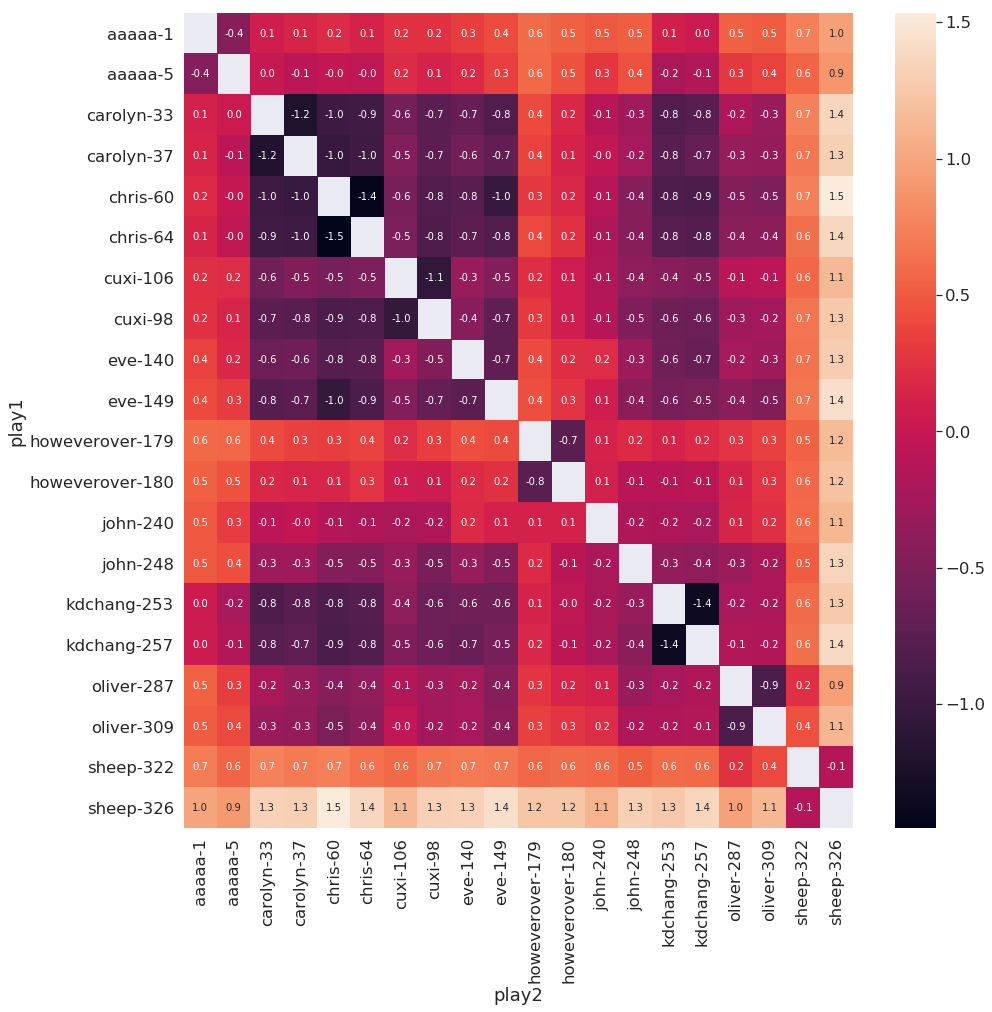

In [14]:
vis_right_df = play_record_df.copy()
vis_right_df = vis_right_df[['drummer_name', 'id']]

vis_df = dtw_df.merge(vis_right_df, left_on='a_id', right_on='id', how='inner')
vis_df = vis_df.merge(vis_right_df, left_on='b_id', right_on='id', how='inner')
vis_df.drop(['id_x', 'id_y'], axis=1, inplace=True)
vis_df = vis_df.rename(index=str, columns={'drummer_name_x': 'a_drummer_name',
                                  'drummer_name_y': 'b_drummer_name'})
vis_df['a_id'] = vis_df['a_id'].apply(str)
vis_df['b_id'] = vis_df['b_id'].apply(str)
vis_df['play1'] = vis_df[['a_drummer_name', 'a_id']].apply(lambda x: '-'.join(x), axis=1)
vis_df['play2'] = vis_df[['b_drummer_name', 'b_id']].apply(lambda x: '-'.join(x), axis=1)
vis_df = vis_df.pivot('play1', 'play2', 'norm_sim')
plt.figure(figsize=(15, 15))
ax = sns.heatmap(vis_df, annot=True, fmt='.1f')

In [15]:
dtw_df = similarity_df.copy()
dtw_df['same'] = (dtw_df['a_id'] == dtw_df['b_id'])
dtw_df = dtw_df[~dtw_df['same']].drop('same', axis=1)

scaler = StandardScaler()
dtw_df[SIMILARITY_COLUMNS] = scaler.fit_transform(dtw_df[SIMILARITY_COLUMNS])
for col in SIMILARITY_COLUMNS:
    dtw_df[col] -= dtw_df.min(axis=0)[col]
    
dtw_df['norm_sim'] = np.sqrt(np.square(dtw_df[SIMILARITY_COLUMNS]).sum(axis=1))
dtw_df

,a_id,b_id,L_A_AI,L_G_AI,L_AX_AI,L_AY_AI,L_AZ_AI,L_GX_AI,L_GY_AI,L_GZ_AI,...,R_GX_FR,R_GY_FR,R_GZ_FR,R_AXY_CORR,R_AYZ_CORR,R_AZX_CORR,R_GXY_CORR,R_GYZ_CORR,R_GZX_CORR,norm_sim
1,1,5,0.595585,0.653836,1.882956,0.634696,1.745086,0.154860,1.514234,1.571436,...,1.168245,1.892229,2.113370,3.005525,2.116006,0.852899,3.403055,0.286431,0.349305,13.785418
2,1,33,1.431817,0.987673,1.722741,1.325127,1.210818,0.262469,1.250778,1.806969,...,1.971636,3.131774,2.787152,1.286376,3.665559,2.737600,2.123387,2.322605,3.394825,17.556351
3,1,37,1.290196,1.295046,2.067362,1.010916,1.162421,0.276642,1.384506,1.831076,...,1.720678,3.148608,2.986678,1.076199,3.816523,3.317387,1.327727,2.334563,3.139004,18.018779
4,1,60,1.547852,1.520881,1.815956,0.442515,1.491555,0.171145,1.652017,1.818950,...,2.057372,3.417229,3.182167,3.395179,1.923148,1.774840,2.283789,1.551505,1.943567,18.415040
5,1,64,1.695170,1.394263,1.568567,0.600432,1.226333,0.179189,1.590304,1.464947,...,1.988457,3.382032,3.284179,3.164821,1.065549,1.985487,2.012134,1.289204,1.892384,17.928685
6,1,98,1.656802,1.054340,2.162087,1.451311,1.643578,0.513949,2.065710,1.656336,...,2.143198,3.114401,3.643048,5.029041,1.857557,2.816216,1.729660,2.743660,2.573376,18.564923
7,1,106,1.528044,1.090341,2.173020,1.593590,1.386911,0.525572,2.058884,2.181663,...,1.602903,3.068886,3.397905,5.301290,2.820474,2.700548,1.790989,1.846693,2.413408,18.687148
8,1,140,1.692617,1.609851,1.863802,1.617100,1.553725,0.320017,1.678139,1.972419,...,2.053878,3.459372,3.391937,4.040567,1.983160,2.441493,3.179793,3.376503,2.143154,18.987129
9,1,149,1.785512,1.661139,1.834829,1.776491,1.250838,0.477271,2.090599,2.239041,...,1.963769,3.723877,3.883966,4.379202,3.081023,2.788420,1.822539,1.706425,2.560881,20.219068
10,1,179,1.630118,2.126210,2.471363,2.806566,1.532671,0.944622,2.361051,3.023057,...,2.827248,3.095224,2.437305,3.418591,4.252301,3.665711,2.467877,2.451382,2.672143,20.735280


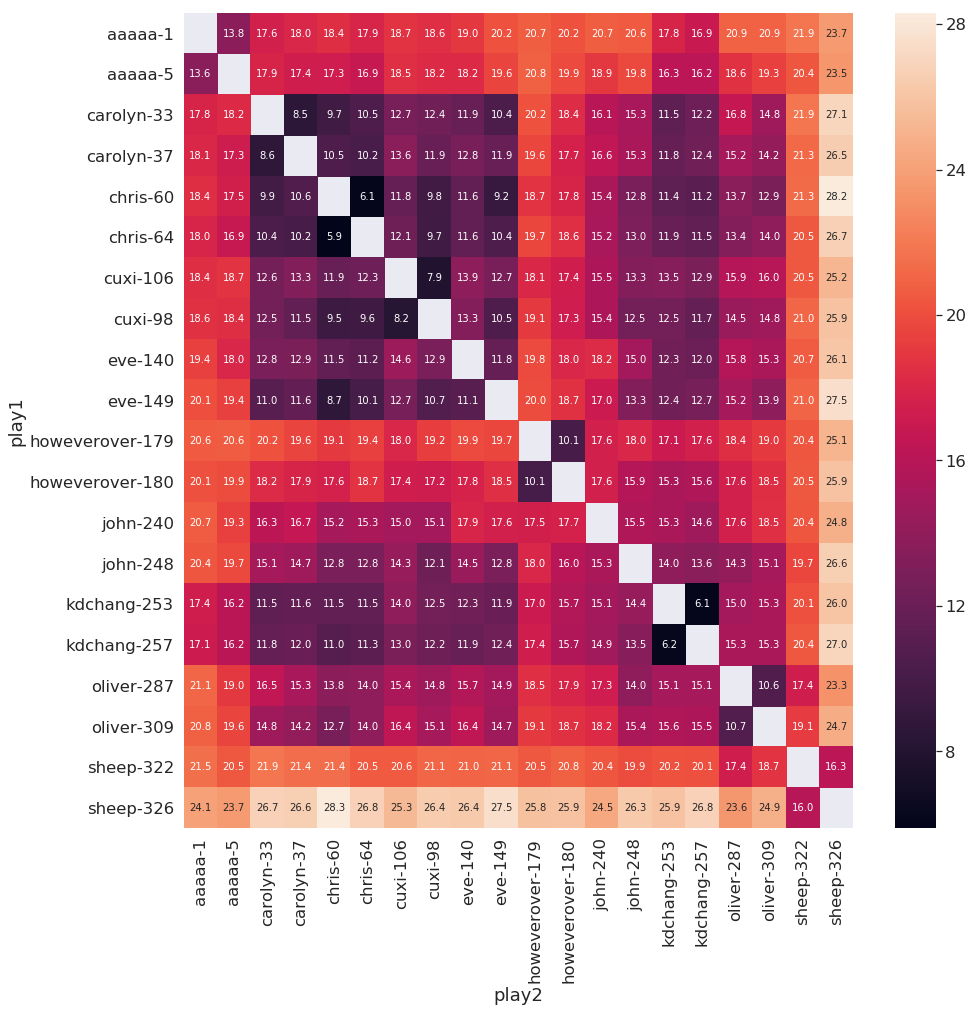

In [16]:
vis_right_df = play_record_df.copy()
vis_right_df = vis_right_df[['drummer_name', 'id']]

vis_df = dtw_df.merge(vis_right_df, left_on='a_id', right_on='id', how='inner')
vis_df = vis_df.merge(vis_right_df, left_on='b_id', right_on='id', how='inner')
vis_df.drop(['id_x', 'id_y'], axis=1, inplace=True)
vis_df = vis_df.rename(index=str, columns={'drummer_name_x': 'a_drummer_name',
                                  'drummer_name_y': 'b_drummer_name'})
vis_df['a_id'] = vis_df['a_id'].apply(str)
vis_df['b_id'] = vis_df['b_id'].apply(str)
vis_df['play1'] = vis_df[['a_drummer_name', 'a_id']].apply(lambda x: '-'.join(x), axis=1)
vis_df['play2'] = vis_df[['b_drummer_name', 'b_id']].apply(lambda x: '-'.join(x), axis=1)
vis_df = vis_df.pivot('play1', 'play2', 'norm_sim')
plt.figure(figsize=(15, 15))
ax = sns.heatmap(vis_df, annot=True, fmt='.1f')

# LGBM

In [17]:
import lightgbm as lgb
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error, mean_absolute_error

In [18]:
score_right_df = play_record_df.copy()
score_right_df = score_right_df[['score', 'id']]

score_df = dtw_df.copy()
score_df = score_df.merge(score_right_df, left_on='a_id', right_on='id', how='inner')
score_df = score_df.merge(score_right_df, left_on='b_id', right_on='id', how='inner')
score_df = score_df[score_df['a_id'] < score_df['b_id']].reset_index(drop=True)
score_df.drop(['id_x', 'id_y'], axis=1, inplace=True)
score_df['score_dif'] = np.abs(score_df['score_x'] - score_df['score_y'])
score_df.drop(['score_x', 'score_y'], axis=1, inplace=True)
score_df

,a_id,b_id,L_A_AI,L_G_AI,L_AX_AI,L_AY_AI,L_AZ_AI,L_GX_AI,L_GY_AI,L_GZ_AI,...,R_GY_FR,R_GZ_FR,R_AXY_CORR,R_AYZ_CORR,R_AZX_CORR,R_GXY_CORR,R_GYZ_CORR,R_GZX_CORR,norm_sim,score_dif
0,1,5,0.595585,0.653836,1.882956,0.634696,1.745086,0.154860,1.514234,1.571436,...,1.892229,2.113370,3.005525,2.116006,0.852899,3.403055,0.286431,0.349305,13.785418,14250
1,1,33,1.431817,0.987673,1.722741,1.325127,1.210818,0.262469,1.250778,1.806969,...,3.131774,2.787152,1.286376,3.665559,2.737600,2.123387,2.322605,3.394825,17.556351,29550
2,5,33,0.841041,0.488580,1.103948,1.578381,0.829785,0.119525,1.282918,0.956167,...,2.317144,3.145421,2.781303,3.582591,3.259607,3.811296,1.404022,4.422098,17.851376,43800
3,1,37,1.290196,1.295046,2.067362,1.010916,1.162421,0.276642,1.384506,1.831076,...,3.148608,2.986678,1.076199,3.816523,3.317387,1.327727,2.334563,3.139004,18.018779,61150
4,5,37,0.698441,0.442117,1.587208,1.226366,0.762701,0.086409,0.780542,0.609058,...,2.302863,2.765901,2.734862,3.490545,3.902607,4.337253,2.171739,4.067924,17.377325,75400
5,33,37,0.799437,0.236696,0.722675,2.950096,0.349159,0.051148,0.326985,0.326386,...,0.305707,0.575740,0.029572,0.000000,0.206965,0.000000,0.161097,0.018620,8.517302,31600
6,1,60,1.547852,1.520881,1.815956,0.442515,1.491555,0.171145,1.652017,1.818950,...,3.417229,3.182167,3.395179,1.923148,1.774840,2.283789,1.551505,1.943567,18.415040,66880
7,5,60,0.985575,0.822877,0.954256,0.508112,0.886409,0.338001,0.913708,0.778929,...,2.605749,2.821733,2.880692,1.416842,2.343437,2.464204,0.908236,2.699634,17.288613,81130
8,33,60,0.333401,0.217703,0.340583,0.981465,0.567383,0.168984,0.359045,0.557552,...,0.922214,1.102761,2.817732,2.680809,1.889497,3.678863,2.448683,1.702374,9.675042,37330
9,37,60,0.457372,0.257135,0.270152,0.970679,0.372721,0.212051,0.172990,0.283056,...,0.596708,0.366698,3.583365,2.721183,2.460603,3.164193,2.656766,1.792909,10.508651,5730


In [19]:
train_df = score_df.drop(['a_id', 'b_id', 'norm_sim'], axis=1).copy()
x = train_df.drop('score_dif', axis=1)
y = train_df['score_dif']

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=0, test_size=0.2)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, random_state=0, test_size=0.5)

train_df

,L_A_AI,L_G_AI,L_AX_AI,L_AY_AI,L_AZ_AI,L_GX_AI,L_GY_AI,L_GZ_AI,L_A_MMI,L_G_MMI,...,R_GX_FR,R_GY_FR,R_GZ_FR,R_AXY_CORR,R_AYZ_CORR,R_AZX_CORR,R_GXY_CORR,R_GYZ_CORR,R_GZX_CORR,score_dif
0,0.595585,0.653836,1.882956,0.634696,1.745086,0.154860,1.514234,1.571436,0.769243,0.617610,...,1.168245,1.892229,2.113370,3.005525,2.116006,0.852899,3.403055,0.286431,0.349305,14250
1,1.431817,0.987673,1.722741,1.325127,1.210818,0.262469,1.250778,1.806969,1.915474,0.860207,...,1.971636,3.131774,2.787152,1.286376,3.665559,2.737600,2.123387,2.322605,3.394825,29550
2,0.841041,0.488580,1.103948,1.578381,0.829785,0.119525,1.282918,0.956167,1.130964,0.439197,...,2.512004,2.317144,3.145421,2.781303,3.582591,3.259607,3.811296,1.404022,4.422098,43800
3,1.290196,1.295046,2.067362,1.010916,1.162421,0.276642,1.384506,1.831076,1.746350,1.101226,...,1.720678,3.148608,2.986678,1.076199,3.816523,3.317387,1.327727,2.334563,3.139004,61150
4,0.698441,0.442117,1.587208,1.226366,0.762701,0.086409,0.780542,0.609058,0.793338,0.414192,...,2.364027,2.302863,2.765901,2.734862,3.490545,3.902607,4.337253,2.171739,4.067924,75400
5,0.799437,0.236696,0.722675,2.950096,0.349159,0.051148,0.326985,0.326386,0.980522,0.289934,...,0.489578,0.305707,0.575740,0.029572,0.000000,0.206965,0.000000,0.161097,0.018620,31600
6,1.547852,1.520881,1.815956,0.442515,1.491555,0.171145,1.652017,1.818950,1.917859,1.317866,...,2.057372,3.417229,3.182167,3.395179,1.923148,1.774840,2.283789,1.551505,1.943567,66880
7,0.985575,0.822877,0.954256,0.508112,0.886409,0.338001,0.913708,0.778929,1.225799,0.737723,...,2.125153,2.605749,2.821733,2.880692,1.416842,2.343437,2.464204,0.908236,2.699634,81130
8,0.333401,0.217703,0.340583,0.981465,0.567383,0.168984,0.359045,0.557552,0.323104,0.219219,...,1.236763,0.922214,1.102761,2.817732,2.680809,1.889497,3.678863,2.448683,1.702374,37330
9,0.457372,0.257135,0.270152,0.970679,0.372721,0.212051,0.172990,0.283056,0.486222,0.294308,...,0.921572,0.596708,0.366698,3.583365,2.721183,2.460603,3.164193,2.656766,1.792909,5730


In [20]:
train_set = lgb.Dataset(x_train, y_train)
valid_set = lgb.Dataset(x_valid, y_valid, free_raw_data=False)
watchlist = [valid_set]

params = dict({
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'application': 'mse',
#     'min_data_in_leaf': 3,
#     'max_depth': 100,
#     'num_leaves': 2 ** 7,
    'min_data': 1,
    'verbosity': 0,
    'metric': ['l2']
})

grid_params = {
    'learning_rate': [0.1, 0.2],
    'max_depth': [8, 10],
}

model = lgb.train(params, train_set=train_set, valid_sets=watchlist,
                  num_boost_round=2000, verbose_eval=20, early_stopping_rounds=100)
y_pred = model.predict(x_test, num_iteration=model.best_iteration)

Training until validation scores don't improve for 100 rounds.
[20]	valid_0's l2: 4.97612e+09
[40]	valid_0's l2: 4.9822e+09
[60]	valid_0's l2: 5.0632e+09
[80]	valid_0's l2: 5.05817e+09
[100]	valid_0's l2: 5.0525e+09
[120]	valid_0's l2: 5.05242e+09
Early stopping, best iteration is:
[25]	valid_0's l2: 4.94548e+09


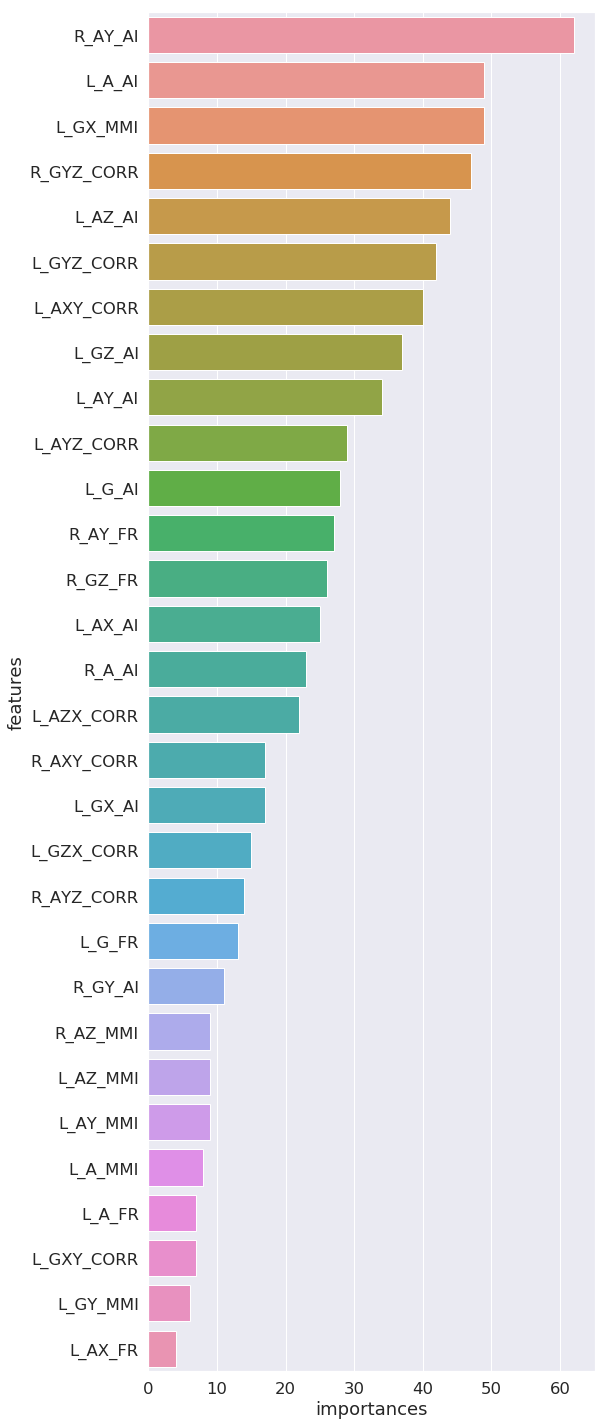

In [21]:
plot_df = pd.DataFrame({'features': train_df.columns[train_df.columns != 'score_dif'],
                        'importances': model.feature_importance()})
plot_df = plot_df.sort_values('importances', ascending=False)
plot_df = plot_df.head(30)
plt.figure(figsize=(8, 25))
sns.barplot(x = plot_df.importances, y = plot_df.features)
plt.show()

In [22]:
compare_df = pd.DataFrame(data={
    'pred': y_pred,
    'test': y_test,
})
compare_df['dif'] = np.abs(compare_df['pred'] - compare_df['test'])
compare_df.reset_index(inplace=True)
compare_df

,index,pred,test,dif
0,108,223929.732391,400,223529.732391
1,74,107806.763722,40100,67706.763722
2,161,100756.522601,70450,30306.522601
3,95,70721.714599,234240,163518.285401
4,123,28427.326081,32500,4072.673919
5,71,76871.448142,135700,58828.551858
6,18,19296.908065,28450,9153.091935
7,124,18845.262910,38230,19384.737090
8,143,58003.285863,91010,33006.714137
9,7,48231.434336,81130,32898.565664


In [23]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [24]:
print('The mae of prediction is:', mean_absolute_error(y_test, y_pred))

The mae of prediction is: 62935.88239985039


In [25]:
print('The rmse of prediction is:', mean_squared_error(y_test, y_pred) ** 0.5)

The rmse of prediction is: 95203.66683863275


In [26]:
print('The mape of prediction is:', mean_absolute_percentage_error(y_test, y_pred))

The mape of prediction is: 1641.6392036766779
